# Legislative election 2021

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
import pickle

In [2]:
# Load data for a given year

def loaddata(year, verbose=True):
    table = pd.read_csv(f'../../data/{year}.csv.zip')
        
    colFilter = ['ПУТИН', 'Путин', 'Единая Россия', 'ЕДИНАЯ РОССИЯ', 'Медведев', 'ДА']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    assert len(col) == 1
    leader = np.squeeze(table[col].values)
    
    colFilter = ['Число избирателей, включенных', 'Число избирателей, внесенных',
                 'Число участников голосования, включенных']
    col = [col for col in table.columns if any([f in col for f in colFilter])]
    assert len(col) == 1
    voters = np.squeeze(table[col].values)
    
    if year != 2020:
        colFilter = ['бюллетеней, выданных']                # should select 3 columns
        col = [col for col in table.columns if any([f in col for f in colFilter])]
        assert len(col) == 3
    else:
        colFilter = ['Число бюллетеней, содержащихся']
        col = [col for col in table.columns if any([f in col for f in colFilter])]
        assert len(col) == 1
    given = np.sum(table[col].values, axis=1)

    if year != 2020:
        colFilter = ['действительных', 'недействительных']  # should select 2 columns
        excludeFilter = ['отметок']  # excludes one additional column in the 2000 data
        col = [col for col in table.columns if any([f in col for f in colFilter]) and 
                                               all([f not in col for f in excludeFilter])]
        assert len(col) == 2
    else:
        colFilter = ['Число бюллетеней, содержащихся']
        col = [col for col in table.columns if any([f in col for f in colFilter])]
        assert len(col) == 1
    received = np.sum(table[col].values, axis=1)
    
    regions = table['region'].values
    tiks    = table['tik'].values
    uiks    = table['uik'].values
    if 'oik' in table.columns:
        oiks = table['oik'].values
    else:
        oiks = []
        
    if verbose:
        print(f'Stations: {np.sum(~np.isnan(leader)):,}')
        print(f'Voters:   {np.sum(voters):,}')
        print(f'Turnout:  {np.sum(given) / np.sum(voters) * 100:.2f}%')
        print(f'Result:   {np.sum(leader) / np.sum(received) * 100:.2f}%')

    return (voters, given, received, leader, regions, tiks, oiks, uiks)

## Integer peaks

In [3]:
voters, given, received, leader, regions, tiks, oiks, uiks = loaddata(2021)

Stations: 96,325
Voters:   109,204,662
Turnout:  51.72%
Result:   49.82%


In [4]:
np.unique([regions[i]+tiks[i] for i in range(uiks.size)]).size

2851

<IPython.core.display.Javascript object>


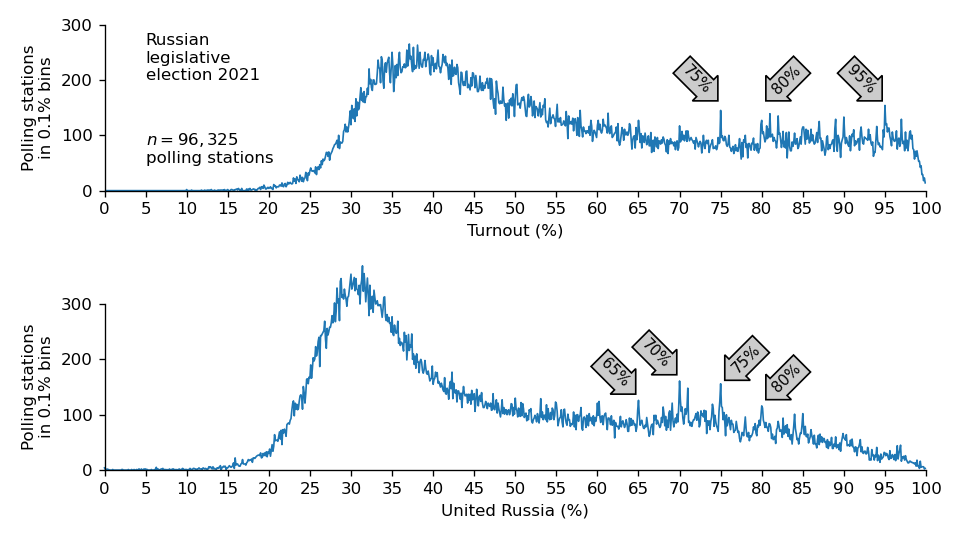

In [6]:
binwidth = 0.1         # Bin width (in percentage points)
addNoise = True        # If add U(-0.5,0.5) noise to the nominators (to remove division artifacts)
weights  = 'off'       # Weights: can be 'off'     (counts polling stations), 
                       #                 'voters'  (counts registered voters),
                       #                 'given'   (counts given ballots)
                       #                 'leader'  (counts ballots for the leader)
minSize  = 0           # Exclude polling stations with number of voters less than minSize

# Settings used in our papers:
# * AOAS-2016:         binwidth=0.1,  addNoise=False, weights='voters', minSize = 0
# * Significance-2016: binwidth=0.25, addNoise=True,  weights='off'     minSize = 0
# * Significance-2018: binwidth=0.1,  addNoise=True,  weights='off'     minSize = 0

######################################################################################

ind = ~np.isnan(received) & (received > 0) & (given < voters) & (voters >= minSize)
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

np.random.seed(42)
noise = np.zeros(np.sum(ind)) if not addNoise else np.random.rand(np.sum(ind)) - .5

w = None
if weights == 'voters': w = voters[ind]
if weights == 'given':  w = given[ind]
if weights == 'leader': w = leader[ind]
h1 = np.histogram(100 * (given[ind]+noise)/voters[ind],    bins=edges, weights = w)[0]
h2 = np.histogram(100 * (leader[ind]+noise)/received[ind], bins=edges, weights = w)[0]

ylbl = 'Polling stations'
if weights == 'voters': ylbl = 'Voters'
if weights == 'given':  ylbl = 'Ballots given'
if weights == 'leader': ylbl = 'Ballots for leader'


plt.figure(figsize=(8,4.5))
plt.subplot(211)
plt.plot(centers, h1, linewidth=1)
plt.xlabel("Turnout (%)")
plt.ylabel('{}\nin {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,5))
# plt.title('Russian election {}'.format(year))
plt.xlim([0,100])
plt.ylim([0,300])
# plt.gca().xaxis.grid(True)

bbox_props = dict(boxstyle="rarrow", fc="#cccccc")
t = plt.gca().text(70, 175, "75%", rotation=-45, size=9, bbox=bbox_props)
t = plt.gca().text(90, 175, "95%", rotation=-45, size=9, bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc="#cccccc")
t = plt.gca().text(81, 175, "80%", rotation=45, size=9, bbox=bbox_props)

plt.text(5, 200, 'Russian\nlegislative\nelection 2021')
plt.text(5, 50,  '$n=96{,}\,325$\npolling stations')

plt.subplot(212)
plt.plot(centers, h2, linewidth=1, clip_on=False)
plt.xlabel("United Russia (%)")
plt.ylabel('{}\nin {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,5))
plt.xlim([0,100])
plt.ylim([0,300])
# plt.gca().xaxis.grid(True)

bbox_props = dict(boxstyle="rarrow", fc="#cccccc")
t = plt.gca().text(65, 185, "70%", rotation=-45, size=9, bbox=bbox_props)
t = plt.gca().text(60, 150, "65%", rotation=-45, size=9, bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc="#cccccc")
t = plt.gca().text(76, 175, "75%", rotation=45, size=9, bbox=bbox_props)
t = plt.gca().text(81, 140, "80%", rotation=45, size=9, bbox=bbox_props)

sns.despine()
plt.tight_layout()
plt.savefig('figures/peaks.png', dpi=200)

## Integer anomalies

In [5]:
# Monte Carlo simulations

import time

def anomaly(voters, given, received, leader, nrep=1000, prctl = 99.9, seed=42, 
            binwidth = .1, period = 1):
    
    # inclusion criteria that we used in the AOAS paper
    ind = (received > 0) & (voters >= 100)
    indd = (given[ind]/voters[ind] <= .99) & (leader[ind]/received[ind] <= .99)
    ind[np.where(ind)[0][~indd]] = False    
    
    p1 = 100 * leader[ind]/received[ind]
    p2 = 100 * given[ind]/voters[ind]
    
    # first dimension:  overall / only result / only turnout
    # second dimension: number of stations, voters, given ballots, leader's ballots
    integer = np.zeros((3,4)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer[0,i] = np.sum(w[(np.abs(p1 - np.round(p1/period)*period)  <= binwidth/2) | 
                                (np.abs(p2 - np.round(p2/period)*period)  <= binwidth/2)])
        integer[1,i] = np.sum(w[ np.abs(p1 - np.round(p1/period)*period)  <= binwidth/2])
        integer[2,i] = np.sum(w[ np.abs(p2 - np.round(p2/period)*period)  <= binwidth/2])

    t = time.time()    
    leader_binom = np.zeros((nrep, np.sum(ind)))
    given_binom  = np.zeros((nrep, np.sum(ind)))
    np.random.seed(seed)
    for n in range(np.sum(ind)):
        if n%1000 == 0:
            print('.', end='')
        leader_binom[:,n] = np.random.binomial(n=received[ind][n], 
                                               p=leader[ind][n]/received[ind][n], 
                                               size=nrep)
        given_binom[:,n]  = np.random.binomial(n=voters[ind][n],   
                                               p=given[ind][n] /voters[ind][n],   
                                               size=nrep)
    t = time.time() - t
    m,s = divmod(t, 60)
    print('{:2.0f}m {:2.0f}s'.format(m,s))
    
    p1 = 100 * leader_binom/received[ind]
    p2 = 100 * given_binom/voters[ind]    
    integer_mc = np.zeros((3,4,nrep)) 
    for i,weights in enumerate([np.ones_like(voters), voters, given, leader]):
        w = weights[ind]
        integer_mc[0,i,:] = np.sum(w * ((np.abs(p1 - np.round(p1/period)*period) <= binwidth/2) | 
                                        (np.abs(p2 - np.round(p2/period)*period) <= binwidth/2)), axis=1)
        integer_mc[1,i,:] = np.sum(w *  (np.abs(p1 - np.round(p1/period)*period) <= binwidth/2), axis=1)
        integer_mc[2,i,:] = np.sum(w *  (np.abs(p2 - np.round(p2/period)*period) <= binwidth/2), axis=1)  
        
    d = integer - np.mean(integer_mc, axis=2) 
    s = np.std(integer_mc, axis=2)
    q = np.percentile(integer_mc, prctl, axis=2) - np.mean(integer_mc, axis=2)
    return (d,s,q)  # anomaly, MC std, MC percentile

In [8]:
years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018, 2020, 2021])

anomalies = np.zeros((years.size, 3, 4))
stds  = np.zeros((years.size, 3, 4))
prctls = np.zeros((years.size, 3, 4))

for i,y in enumerate(years):
    voters, given, received, leader, regions, oiks, tiks, uiks = loaddata(y, verbose=False)
    a = anomaly(voters, given, received, leader)
    anomalies[i,:,:] = a[0]
    stds[i,:,:]      = a[1]
    prctls[i,:,:]    = a[2]
    
with open('montecarlo.pickle', 'wb') as f:
    pickle.dump([anomalies, stds, prctls, years], f)

..................................................................................... 2m  3s
........................................................................................ 2m 27s
...................................................................................... 2m 31s
...................................................................................... 2m 34s
....................................................................................... 2m 48s
....................................................................................... 2m 36s
........................................................................................ 2m 21s
........................................................................................... 2m 22s
............................................................................................ 3m  4s
........................................................................................... 2m 49s
.......................................

[ 108.577   84.458  933.748  722.725 1722.779 1003.477 1159.585 1502.391
 1708.839 3610.885 1309.768]


<IPython.core.display.Javascript object>


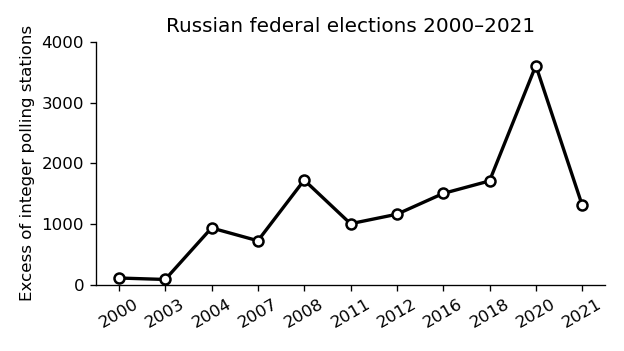

In [5]:
with open('montecarlo.pickle', 'rb') as f:
    anomalies, stds, prctls, years = pickle.load(f)
print(anomalies[:,0,0])

plt.figure(figsize=(8 * 0.65, 4.5 * 0.65))
plt.plot(anomalies[:,0,0], '-ko', markerfacecolor='w', linewidth=2, markeredgewidth=1.5)
plt.ylabel('Excess of integer polling stations')
plt.title('Russian federal elections 2000–2021')
plt.ylim([0, 4000])
plt.xticks(np.arange(years.size), years, rotation=30)

sns.despine()
plt.tight_layout()

plt.savefig('figures/integer-anomalies.png', dpi=200)

<IPython.core.display.Javascript object>


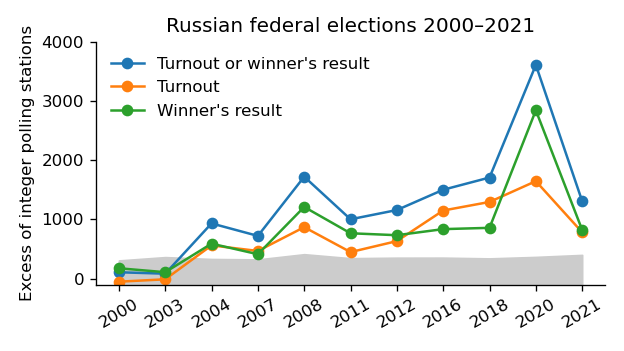

In [34]:
plt.figure(figsize=(8 * 0.65, 4.5 * 0.65))

plt.plot(anomalies[:,0,0], '-o')
plt.plot(anomalies[:,2,0], '-o')
plt.plot(anomalies[:,1,0], '-o')
plt.fill_between(np.arange(len(years)), plt.ylim()[0], prctls[:,0,0], color=[.8,.8,.8])
plt.legend(("Turnout or winner's result", "Turnout", "Winner's result"), frameon=False)
plt.ylabel('Excess of integer polling stations')
plt.title('Russian federal elections 2000–2021')
plt.ylim([-100, 4000])
plt.xticks(np.arange(years.size), years, rotation=30)

sns.despine()
plt.tight_layout()

plt.savefig('figures/integer-anomalies-all.png', dpi=200)

## 2D histograms

Stations: 96,325
Voters:   109,204,662
Turnout:  51.72%
Result:   49.82%


<IPython.core.display.Javascript object>


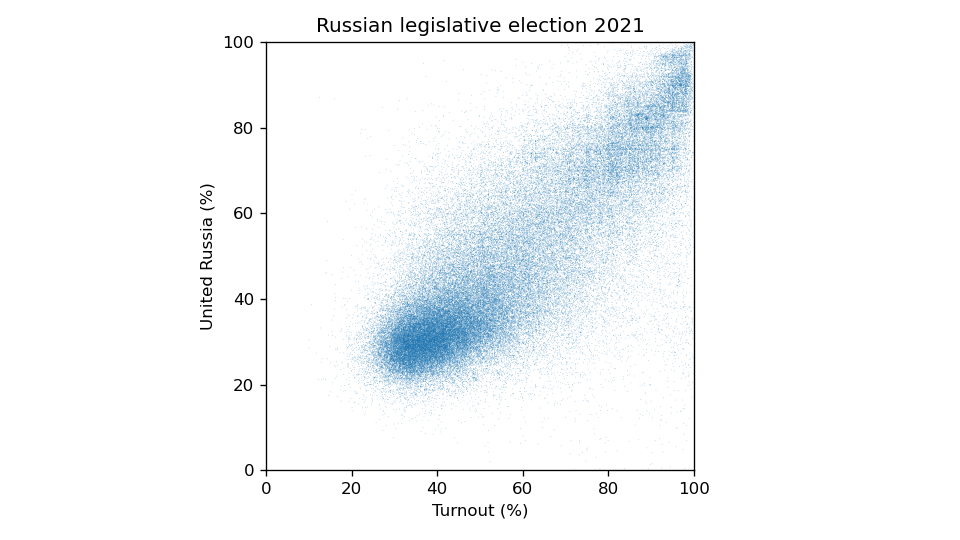

In [4]:
voters, given, received, leader, regions, tiks, oiks, uiks = loaddata(2021)

ind = ~np.isnan(received) & (received > 0) & (given < voters)

np.random.seed(42)

noise = np.random.rand(np.sum(ind)) - .5
v = (given[ind]+noise)/voters[ind] * 100

noise = np.random.rand(np.sum(ind)) - .5
p = (leader[ind]+noise)/received[ind] * 100

plt.figure(figsize=(8,4.5))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(v,p, s=.2, alpha=.5, edgecolor='none')
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Turnout (%)')
plt.ylabel('United Russia (%)')
plt.title('Russian legislative election 2021')

plt.tight_layout()
plt.savefig('figures/comet.png', dpi=200)

<IPython.core.display.Javascript object>


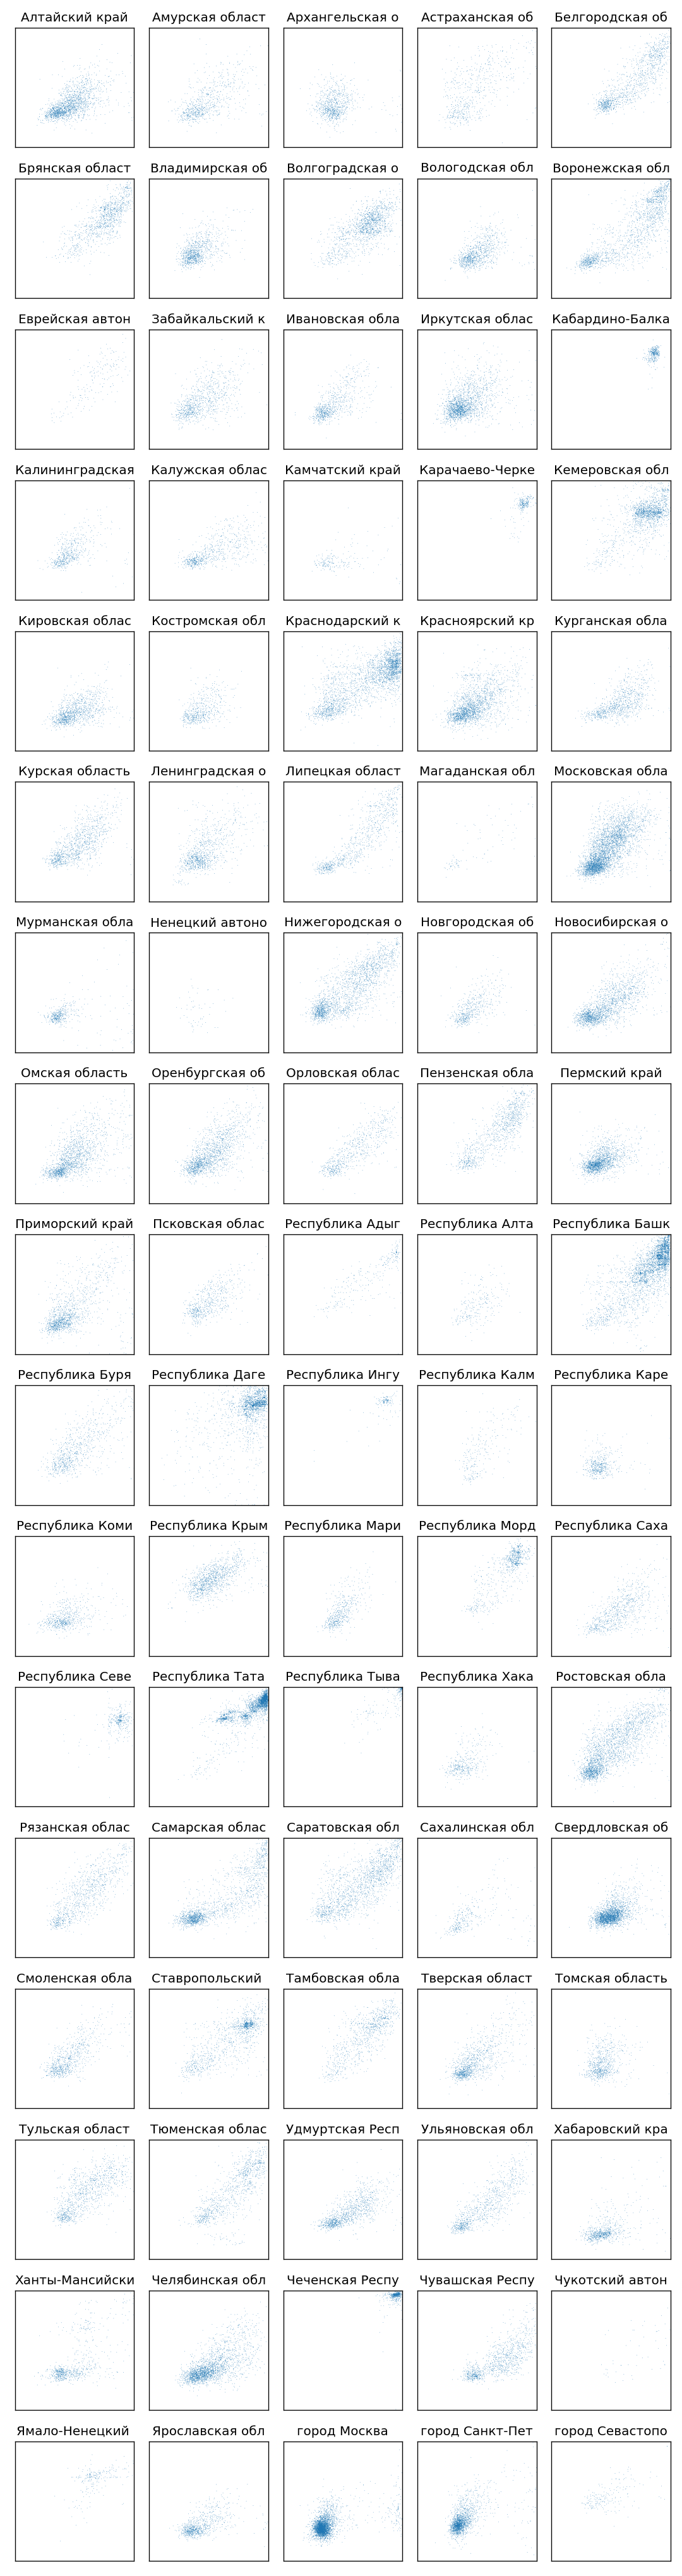

In [36]:
ind = ~np.isnan(received) & (received > 0) & (given < voters)

noise = np.random.rand(np.sum(ind)) - .5
v = (given[ind]+noise)/voters[ind] * 100

noise = np.random.rand(np.sum(ind)) - .5
p = (leader[ind]+noise)/received[ind] * 100

regs = np.unique(regions)

plt.figure(figsize=(9,34))
for i,r in enumerate(np.unique(regions)):
    plt.subplot(17,5,i+1)
    plt.title(r[:15])
    ind2 = (regions == r)
    ind2 = ind2[ind]

    plt.scatter(v[ind2], p[ind2], s=.2, edgecolors='none')#, s=.1, alpha=.3)
    plt.xlim([0,100])
    plt.ylim([0,100])

    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig('figures/regions.png', dpi=100)

<IPython.core.display.Javascript object>


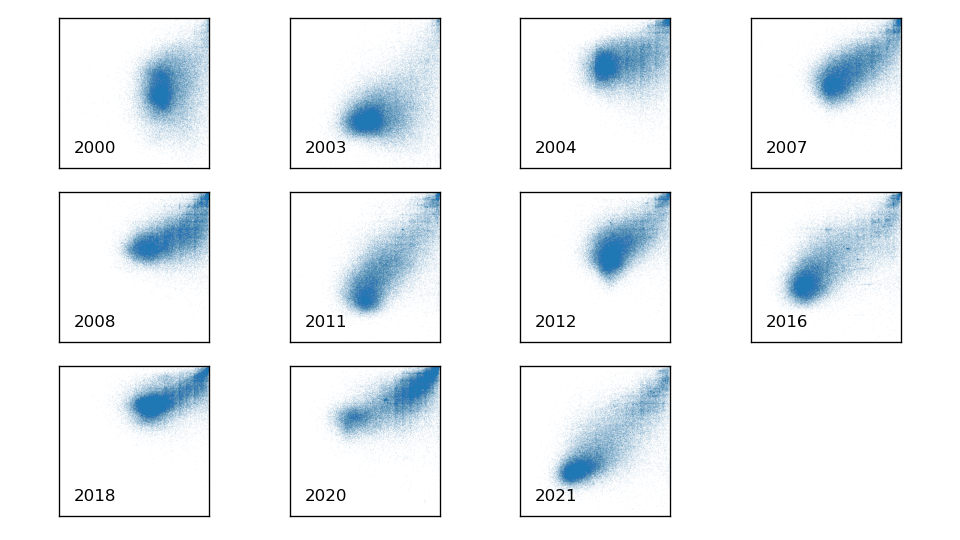

In [21]:
years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018, 2020, 2021])

plt.figure(figsize=(8, 4.5))

for i,year in enumerate(years):
    voters, given, received, leader, _, _, _, _ = loaddata(year, verbose=False)

    ind = ~np.isnan(received) & (received > 0) & (given < voters)

    noise = np.random.rand(np.sum(ind)) - .5
    v = (given[ind]+noise)/voters[ind] * 100

    noise = np.random.rand(np.sum(ind)) - .5
    p = (leader[ind]+noise)/received[ind] * 100

    plt.subplot(3,4,i+1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.scatter(v,p, s=.2, alpha=.1, edgecolor='none')
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.xticks([])
    plt.yticks([])
    
    plt.text(10,10,year)
    
plt.tight_layout()
plt.savefig('figures/allcomets.png', dpi=200)

<IPython.core.display.Javascript object>


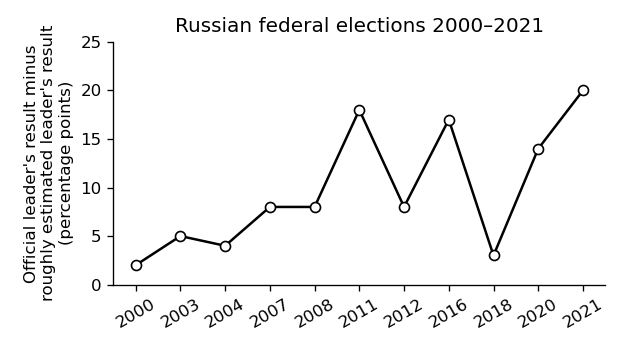

In [5]:
years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018, 2020, 2021])

comet_kern = np.array([[69, 50], [53, 32], [55, 67], [56, 56], [60, 62], [51, 31], 
                       [60, 55], [36, 37], [62, 73], [43, 64], [35, 29]])

official = np.zeros_like(years)

for i,year in enumerate(years):
    voters, given, received, leader, _, _, _, _ = loaddata(year, verbose=False)
    official[i] = np.sum(leader) / np.sum(received) * 100

plt.figure(figsize=(8 * 0.65, 4.5 * 0.65))
plt.plot(official - comet_kern[:,1], '-o', color='k', markerfacecolor='w', clip_on=False)
plt.ylabel('Official leader\'s result minus\nroughly estimated leader\'s result\n(percentage points)')
plt.title('Russian federal elections 2000–2021')
plt.ylim([0, 25])
plt.xticks(np.arange(years.size), years, rotation=30)

sns.despine()
plt.tight_layout()

plt.savefig('figures/official-minus-comet-kern.png', dpi=200)

## Virtual vs physical voting in Moscow

In [3]:
voters, given, received, leader, regions, tiks, oiks, uiks = loaddata(2021)

Stations: 96,325
Voters:   109,204,662
Turnout:  51.72%
Result:   49.82%


<IPython.core.display.Javascript object>


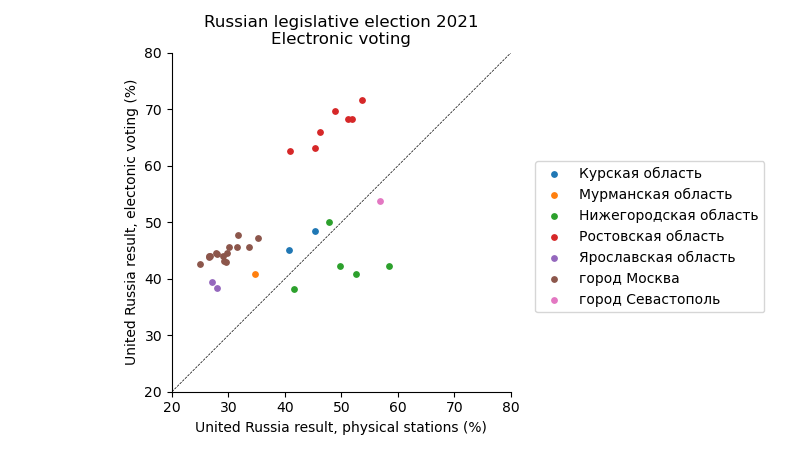

In [25]:
count = 0

plt.figure(figsize=(8, 4.5))
plt.gca().set_aspect('equal', adjustable='box')

for region in np.unique(regions):
    if np.sum((regions==region) & (voters>=10000)) > 0:
        count += 1

        region_oiks = np.unique(oiks[regions==region])
        region_results = np.zeros((region_oiks.size, 2))
    
        for i,t in enumerate(region_oiks):
            ind = (regions==region) & (oiks==t) & (voters<10000)
            results_physical = np.sum(leader[ind]) / np.sum(received[ind]) * 100
    
            ind = (regions==region) & (oiks==t) & (voters>10000)
            results_virtual = np.sum(leader[ind]) / np.sum(received[ind]) * 100
    
            region_results[i] = (results_physical, results_virtual)
    
        plt.scatter(region_results[:,0], region_results[:,1], s=15, label=region)

plt.xlim([20,80])
plt.ylim([20,80])
plt.plot([20,80], [20,80], 'k--', linewidth=0.5)
plt.xlabel('United Russia result, physical stations (%)')
plt.ylabel('United Russia result, electonic voting (%)')
# plt.title(f'{region}')
plt.legend(bbox_to_anchor=(1.05, 0.7))
plt.title('Russian legislative election 2021\nElectronic voting')
plt.xticks(np.arange(20,81,10))
plt.yticks(np.arange(20,81,10))
        
sns.despine()
plt.tight_layout()
plt.savefig('figures/electronic.png', dpi=200)

## Correlation with Covid undercount

In [49]:
voters, given, received, leader, regions, tiks, oiks, uiks = loaddata(2021)

Stations: 96,325
Voters:   109,204,662
Turnout:  51.72%
Result:   49.82%


In [50]:
def rename(regions):
    regions[regions=='Hижегородская область'] = 'Нижегородская область'

    # in EMISS files
    regions[regions=='Город Москва столица Российской Федерации город федерального значения'] = 'Москва'
    regions[regions=='Город Санкт-Петербург город федерального значения'] = 'Санкт-Петербург'
    regions[regions=='Город федерального значения Севастополь'] = 'Севастополь'
    regions[regions=='Ненецкий автономный округ (Архангельская область)'] = 'Ненецкий АО'
    regions[regions=='Архангельская область (кроме Ненецкого автономного округа)'] = 'Архангельская область без АО'
    regions[regions=='Ханты-Мансийский автономный округ - Югра (Тюменская область)'] = 'Ханты-Мансийский АО'
    regions[regions=='Ямало-Ненецкий автономный округ (Тюменская область)'] = 'Ямало-Hенецкий АО'
    regions[regions=='Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)'] = 'Тюменская область без АО'
    regions[regions=='Чукотский автономный округ'] = 'Чукотский АО'
    regions[regions=='Еврейская автономная область'] = 'Еврейская АО'
    regions[regions=='Республика Адыгея (Адыгея)'] = 'Республика Адыгея'
    regions[regions=='Республика Татарстан (Татарстан)'] = 'Республика Татарстан' 
    regions[regions=='Чувашская Республика - Чувашия'] = 'Чувашская Республика'
    regions[regions=='Республика Северная Осетия-Алания'] = 'Северная Осетия'
    regions[regions=='Республика Саха (Якутия)'] = 'Якутия'
    regions[regions=='Кабардино-Балкарская Республика'] = 'Кабардино-Балкария'
    regions[regions=='Карачаево-Черкесская Республика'] = 'Карачаево-Черкесия'
    regions[regions=='Кемеровская область - Кузбасс'] = 'Кемеровская область'
    
    # in addition in Rosstat files
    regions[regions=='г.Москва'] = 'Москва'
    regions[regions=='г.Санкт-Петербург'] = 'Санкт-Петербург'
    regions[regions=='г.Севастополь'] = 'Севастополь'
    regions[regions=='г. Севастополь'] = 'Севастополь'
    regions[regions=='Hенецкий авт.округ'] = 'Ненецкий АО'
    regions[regions=='Архангельская область без автономии'] = 'Архангельская область без АО'
    regions[regions=='Ханты-Мансийский авт.округ-Югра'] = 'Ханты-Мансийский АО'
    regions[regions=='Ханты-Мансийский автономный округ - Югра'] = 'Ханты-Мансийский АО'
    regions[regions=='Ямало-Hенецкий авт.округ'] = 'Ямало-Hенецкий АО'
    regions[regions=='Ямало-Hенецкий автономный округ'] = 'Ямало-Hенецкий АО'
    regions[regions=='Тюменская область без автономии'] = 'Тюменская область без АО'
    regions[regions=='Чукотский авт.округ'] = 'Чукотский АО'
    regions[regions=='Республика Татарстан(Татарстан)'] = 'Республика Татарстан'
    regions[regions=='Чувашская Республика(Чувашия)'] = 'Чувашская Республика'
    regions[regions=='Чувашская Республика (Чувашия)'] = 'Чувашская Республика'
    regions[regions=='Республика Северная Осетия- Алания'] = 'Северная Осетия'
    
    # in addition in Stopcoronavirus files
    regions[regions=='Ненецкий автономный округ'] = 'Ненецкий АО'
    regions[regions=='Республика Северная Осетия — Алания'] = 'Северная Осетия'
    regions[regions=='Республика Чувашия'] = 'Чувашская Республика'
    regions[regions=='Чукотский автономный округ'] = 'Чукотский АО'
    regions[regions=='Ямало-Ненецкий автономный округ'] = 'Ямало-Hенецкий АО'
    if 'Архангельская область без АО' not in regions:
        regions[regions=='Архангельская область'] = 'Архангельская область без АО'
        regions[regions=='Тюменская область'] = 'Тюменская область без АО'
        
    ###########
    regions[regions=='город Москва'] = 'Москва'
    regions[regions=='город Санкт-Петербург'] = 'Санкт-Петербург'
    regions[regions=='город Севастополь'] = 'Севастополь'
    regions[regions=='Республика Северная Осетия - Алания'] = 'Северная Осетия'        
        
    return regions

In [51]:
regions = rename(regions)

In [52]:
covid = pd.read_csv('../../excess-mortality/russia_excess_deaths_summary.csv')
regions_covid = covid.values[1:,0]
undercounts = covid.values[1:,4]

regions_result = np.zeros(regions_covid.size)
for i, reg in enumerate(regions_covid):
    regions_result[i] = np.sum(leader[regions==reg]) / np.sum(received[regions==reg]) * 100

<IPython.core.display.Javascript object>


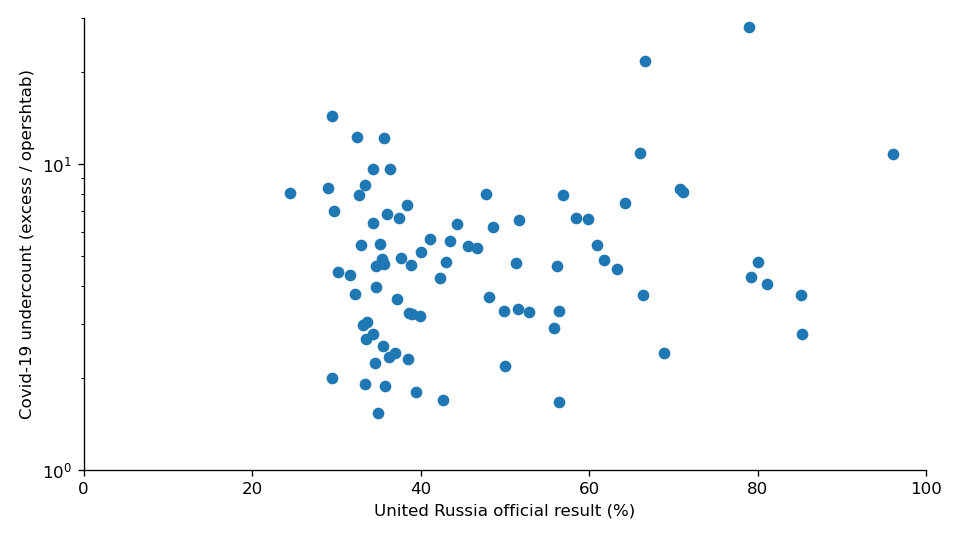

In [53]:
plt.figure(figsize=(8,4.5))
# plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(regions_result, undercounts)
plt.xlim([0,100])
plt.ylim([1,30])
plt.xlabel('United Russia official result (%)')
plt.ylabel('Covid-19 undercount (excess / opershtab)')
plt.yscale('log')

sns.despine()
plt.tight_layout()
plt.savefig('figures/covid.png', dpi=200)

In [54]:
regions_covid[(undercounts>10)&(regions_result<32)]

array(['Кировская область'], dtype=object)

## Kireev anomaly

In [56]:
data = pd.read_csv('../../data/2021.csv.zip')

regions = data['region'].values
tiks = data['tik'].values
parties = data.columns[17:31]
votes = data.values[:,17:31]

for region in np.unique(regions):
    for tik in np.unique(tiks[regions==region]):
        ind = (regions==region) & (tiks==tik)
        for party in range(votes.shape[1]):
            if (np.sum(votes[ind,party]==1) > 20) & (np.sum(votes[ind,party]==2) > 20) & \
               (np.sum(votes[ind,party]==0) < 10):
                print(f'{region} - {tik} - {parties[party]}')

Кабардино-Балкарская Республика - Нальчикская городская - 2. Политическая партия "Российская экологическая партия "ЗЕЛЁНЫЕ"
Республика Башкортостан - Дюртюлинская - 6. Партия СПРАВЕДЛИВАЯ РОССИЯ – ЗА ПРАВДУ
Республика Башкортостан - Стерлитамакская городская - 7. Политическая партия "Российская объединенная демократическая партия "ЯБЛОКО"
Республика Башкортостан - Уфа, Калининская - 12. Политическая партия ЗЕЛЕНАЯ АЛЬТЕРНАТИВА
Республика Башкортостан - Уфа, Октябрьская - 8. Всероссийская политическая партия "ПАРТИЯ РОСТА"
Республика Башкортостан - Уфа, Октябрьская - 9. Политическая партия РОССИЙСКАЯ ПАРТИЯ СВОБОДЫ И СПРАВЕДЛИВОСТИ
Республика Башкортостан - Уфа, Октябрьская - 12. Политическая партия ЗЕЛЕНАЯ АЛЬТЕРНАТИВА
Республика Башкортостан - Уфа, Октябрьская - 13. ВСЕРОССИЙСКАЯ ПОЛИТИЧЕСКАЯ ПАРТИЯ "РОДИНА"
Республика Башкортостан - Хайбуллинская - 6. Партия СПРАВЕДЛИВАЯ РОССИЯ – ЗА ПРАВДУ
Республика Татарстан (Татарстан) - Лаишевская - 13. ВСЕРОССИЙСКАЯ ПОЛИТИЧЕСКАЯ ПАРТИЯ "РОДИНА"


## All elections together!

In [3]:
years = np.array([2000, 2003, 2004, 2007, 2008, 2011, 2012, 2016, 2018, 2020, 2021])

voters = []
given = []
received = []
leader = []
y = []

for i,year in enumerate(years):
    print('.', end='')
    
    voters_, given_, received_, leader_, _, _, _, _ = loaddata(year, verbose=False)
    
    voters = np.concatenate((voters,voters_))
    given = np.concatenate((given,given_))
    received = np.concatenate((received,received_))
    leader = np.concatenate((leader,leader_))
    
    y = np.concatenate((y, np.ones_like(voters_)*i))

...........

In [10]:
ind = ~np.isnan(received) & (received > 0) & (given < voters)

np.random.seed(42)

noise = np.random.rand(np.sum(ind)) - .5
v = (given[ind]+noise)/voters[ind] * 100

noise = np.random.rand(np.sum(ind)) - .5
p = (leader[ind]+noise)/received[ind] * 100

np.savetxt('all-russian-elections.csv', 
           np.concatenate((v[:,np.newaxis],p[:,np.newaxis]),axis=1), 
           delimiter=',',
           fmt='%.3f',
           comments='',
           header="turnout,leader's result")

<IPython.core.display.Javascript object>


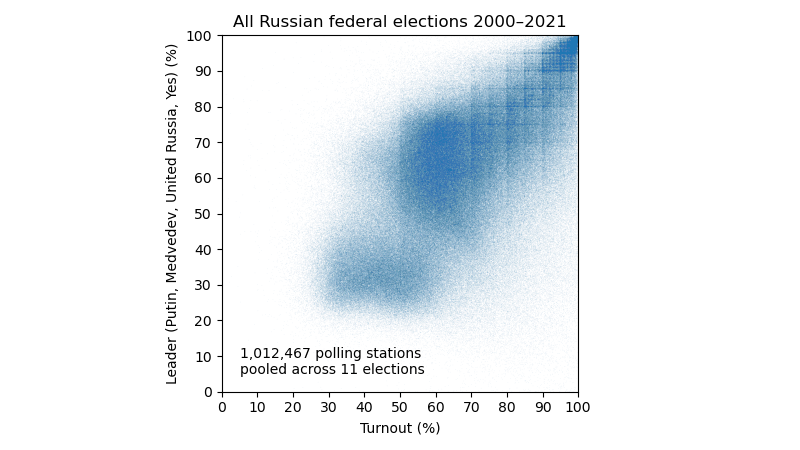

In [11]:
plt.figure(figsize=(8,4.5))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(v, p, s=.2, alpha=.1, edgecolor='none')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.xlabel('Turnout (%)')
plt.ylabel('Leader (Putin, Medvedev, United Russia, Yes) (%)')
plt.title('All Russian federal elections 2000–2021')
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0,101,10))

plt.text(5, 5, f'{np.sum(ind):,} polling stations\npooled across {years.size} elections', fontsize=10)

plt.tight_layout()
plt.savefig('figures/comet-alltogether.png', dpi=300)

<IPython.core.display.Javascript object>


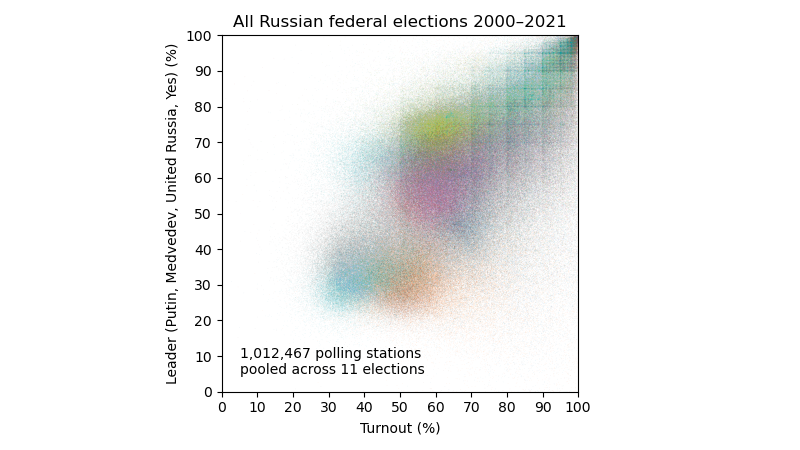

In [15]:
plt.figure(figsize=(8,4.5))
plt.set_cmap('tab10')

plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(v, p, c=y[ind], s=.2, alpha=.1, edgecolor='none')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.xlabel('Turnout (%)')
plt.ylabel('Leader (Putin, Medvedev, United Russia, Yes) (%)')
plt.title('All Russian federal elections 2000–2021')
plt.xticks(np.arange(0,101,10))
plt.yticks(np.arange(0,101,10))

plt.text(5, 5, f'{np.sum(ind):,} polling stations\npooled across {years.size} elections', fontsize=10)

plt.legend()

plt.tight_layout()
# plt.savefig('figures/comet-alltogether-colored.png', dpi=300)

<IPython.core.display.Javascript object>


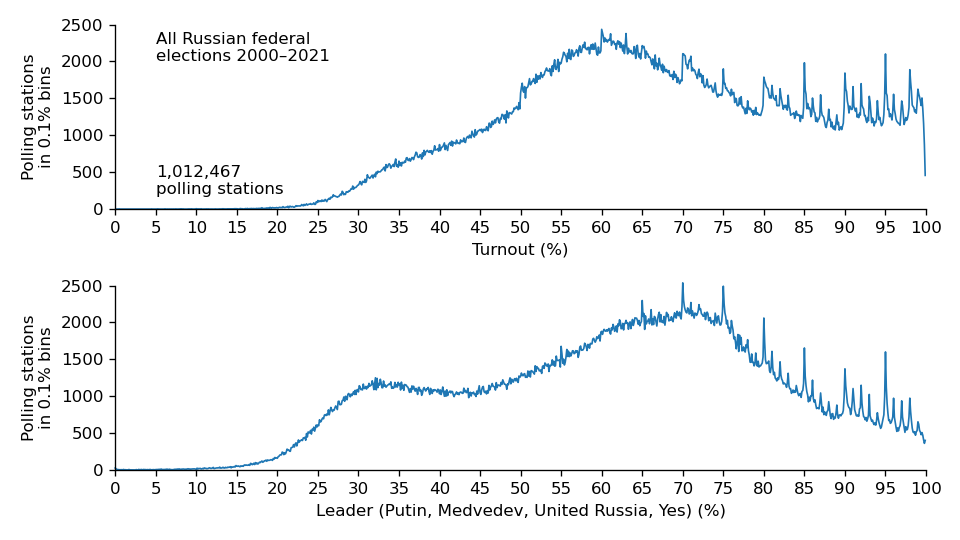

In [10]:
binwidth = 0.1         # Bin width (in percentage points)
addNoise = True        # If add U(-0.5,0.5) noise to the nominators (to remove division artifacts)
weights  = 'off'       # Weights: can be 'off'     (counts polling stations), 
                       #                 'voters'  (counts registered voters),
                       #                 'given'   (counts given ballots)
                       #                 'leader'  (counts ballots for the leader)
minSize  = 0           # Exclude polling stations with number of voters less than minSize

# Settings used in our papers:
# * AOAS-2016:         binwidth=0.1,  addNoise=False, weights='voters', minSize = 0
# * Significance-2016: binwidth=0.25, addNoise=True,  weights='off'     minSize = 0
# * Significance-2018: binwidth=0.1,  addNoise=True,  weights='off'     minSize = 0

######################################################################################

ind = ~np.isnan(received) & (received > 0) & (given < voters) & (voters >= minSize)
edges = np.arange(-binwidth/2, 100+binwidth/2, binwidth)
centers = np.arange(0,100,binwidth)

np.random.seed(42)
noise = np.zeros(np.sum(ind)) if not addNoise else np.random.rand(np.sum(ind)) - .5

w = None
if weights == 'voters': w = voters[ind]
if weights == 'given':  w = given[ind]
if weights == 'leader': w = leader[ind]
h1 = np.histogram(100 * (given[ind]+noise)/voters[ind],    bins=edges, weights = w)[0]
h2 = np.histogram(100 * (leader[ind]+noise)/received[ind], bins=edges, weights = w)[0]

ylbl = 'Polling stations'
if weights == 'voters': ylbl = 'Voters'
if weights == 'given':  ylbl = 'Ballots given'
if weights == 'leader': ylbl = 'Ballots for leader'


plt.figure(figsize=(8,4.5))
plt.subplot(211)
plt.plot(centers, h1, linewidth=1)
plt.xlabel("Turnout (%)")
plt.ylabel('{}\nin {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,5))
# plt.title('Russian election {}'.format(year))
plt.xlim([0,100])
plt.ylim([0,2500])
# plt.gca().xaxis.grid(True)

plt.text(5, 2000, 'All Russian federal\nelections 2000–2021')
plt.text(5, 200,  f'{np.sum(ind):,}\npolling stations')

plt.subplot(212)
plt.plot(centers, h2, linewidth=1, clip_on=False)
plt.xlabel("Leader (Putin, Medvedev, United Russia, Yes) (%)")
plt.ylabel('{}\nin {}% bins'.format(ylbl, binwidth))
plt.xticks(np.arange(0,101,5))
plt.xlim([0,100])
plt.ylim([0,2500])
# plt.gca().xaxis.grid(True)

sns.despine()
plt.tight_layout()
plt.savefig('figures/peaks-alltogether.png', dpi=300)